## Notebook: Unsupervised learning


In this notebook, you will learn how to use unsupervised learning to discover  patterns in text.

We cover:
- Co-occurrence: the basic building block  
- LDA: classic topic modeling with word co-occurrence  
- BERTopic: transformer-based topic modeling with embeddings and clustering

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/merged_scopus.csv")

valid_types = ['Article', 'Book', 'Book chapter', 'Review']
df = df[df['Document Type'].isin(valid_types)]

df['text'] = df['Title'].fillna('') + '. ' + df['Abstract'].fillna('')

### Word co-occurrence

In [3]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=250)
X = vectorizer.fit_transform(df['text'])

# Raw co-occurrence matrix
co_matrix = (X.T @ X).toarray()
co_df = pd.DataFrame(co_matrix, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
co_df


,19,2019,2020,2021,2022,2023,2024,2025,academic,access,...,use,used,user,users,using,value,various,work,world,years
19,12542,485,1739,1078,845,510,270,113,162,275,...,977,1366,297,801,2311,190,465,524,576,204
2019,485,920,210,126,148,117,77,21,65,61,...,255,288,72,155,473,90,97,103,82,133
2020,1739,210,1425,316,217,152,72,29,56,124,...,441,456,95,229,788,92,158,143,140,186
2021,1078,126,316,1186,176,129,74,29,83,92,...,396,438,108,208,690,119,189,152,140,167
2022,845,148,217,176,1245,179,139,64,78,95,...,448,460,103,209,786,102,154,131,109,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
value,190,90,92,119,102,141,153,90,119,44,...,293,330,144,130,600,1780,162,135,61,70
various,465,97,158,189,154,200,239,134,132,116,...,457,440,192,200,897,162,1399,193,181,151
work,524,103,143,152,131,151,199,101,122,146,...,580,392,171,223,780,135,193,1852,140,98
world,576,82,140,140,109,104,105,83,51,72,...,262,274,160,134,484,61,181,140,857,80



### Normalization for word frequency.


In [4]:

import numpy as np

N = X.shape[0]
word1, word2 = 'policy', 'analysis'
i, j = vectorizer.vocabulary_.get(word1), vectorizer.vocabulary_.get(word2)

if i is not None and j is not None:
    p_xy = co_matrix[i, j] / N
    p_x = X[:, i].sum() / N
    p_y = X[:, j].sum() / N
    pmi = np.log2(p_xy / (p_x * p_y))
    print(f"Point-wise mutual information ({word1}, {word2}) = {pmi:.3f}")
else:
    print("Words not found.")


Point-wise mutual information (policy, analysis) = 0.045



### Co-occurrence graph

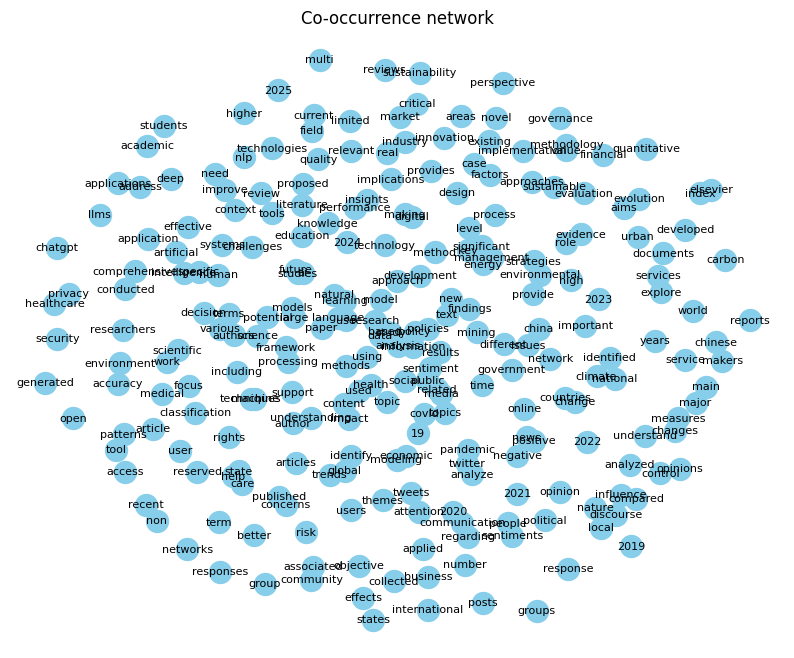

In [5]:
import networkx as nx

G = nx.Graph()
threshold = 50

for w1 in co_df.columns:
    for w2 in co_df.columns:
        if w1 != w2 and co_df.loc[w1, w2] > threshold:
            G.add_edge(w1, w2, weight=co_df.loc[w1, w2])

pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=250, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Co-occurrence network")
plt.axis('off')
plt.show()


## LDA topic modeling

In [6]:
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

texts = []
for doc in df['text']:
    tokens = doc.lower().split()
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 2]
    texts.append(tokens)
    
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=5)
lda_model.print_topics(num_topics=5, num_words=10)

[(0,
  '0.012*"health" + 0.008*"research" + 0.008*"topics" + 0.008*"climate" + 0.008*"topic" + 0.006*"study" + 0.004*"analysis" + 0.004*"change" + 0.004*"social" + 0.004*"care"'),
 (1,
  '0.020*"policy" + 0.008*"policies" + 0.007*"development" + 0.006*"study" + 0.006*"research" + 0.006*"analysis" + 0.006*"text" + 0.004*"technology" + 0.004*"innovation" + 0.004*"mining"'),
 (2,
  '0.008*"data" + 0.007*"research" + 0.006*"language" + 0.005*"policy" + 0.005*"analysis" + 0.004*"study" + 0.004*"learning" + 0.004*"use" + 0.004*"energy" + 0.003*"natural"'),
 (3,
  '0.018*"sentiment" + 0.016*"public" + 0.016*"social" + 0.012*"media" + 0.011*"analysis" + 0.007*"covid-19" + 0.007*"twitter" + 0.007*"study" + 0.007*"tweets" + 0.005*"negative"'),
 (4,
  '0.010*"policy" + 0.008*"data" + 0.007*"text" + 0.007*"analysis" + 0.006*"research" + 0.006*"model" + 0.005*"information" + 0.005*"based" + 0.004*"results" + 0.004*"mining"')]

In [7]:
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
print(f"Coherence: {coherence_model.get_coherence():.3f}")

# Gensim log perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Log Perplexity: {perplexity:.3f}  (lower is better)")

Coherence: 0.409
Log Perplexity: -8.934  (lower is better)


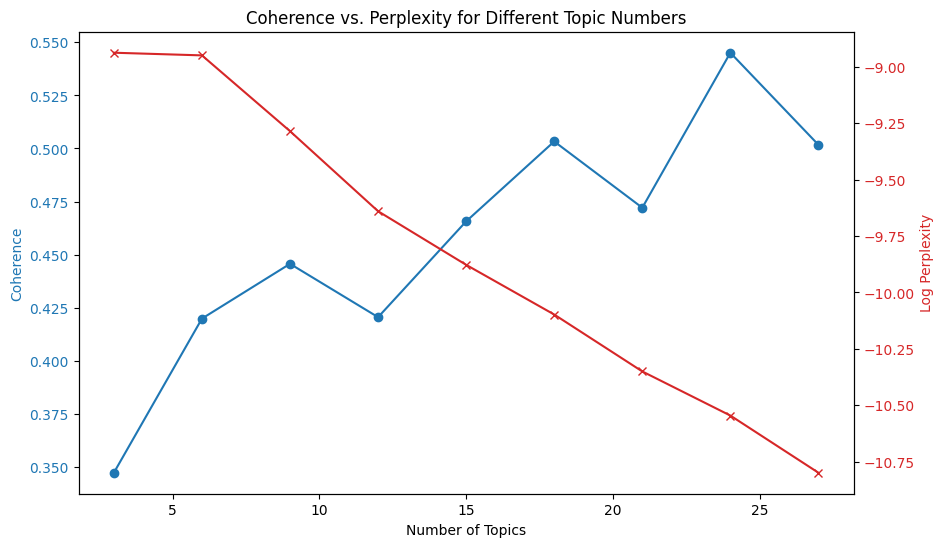

In [8]:
# Range of topic numbers
topic_nums = list(range(3, 30, 3))  # starts at 3, step 3
coherences = []
perplexities = []

for n in topic_nums:
    temp_model = models.LdaModel(corpus=corpus, num_topics=n, id2word=dictionary, passes=5)
    coh = CoherenceModel(model=temp_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    perp = temp_model.log_perplexity(corpus)
    coherences.append(coh)
    perplexities.append(perp)
    #print(f"Topics: {n} | Coherence: {coh:.3f} | Log Perplexity: {perp:.3f}")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(topic_nums, coherences, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add a second y-axis for perplexity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Perplexity', color=color)
ax2.plot(topic_nums, perplexities, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Coherence vs. Perplexity for Different Topic Numbers')
plt.show()

### Interactive LDAVis

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

lda_model = models.LdaModel(corpus=corpus, num_topics=21, id2word=dictionary, passes=5)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.254972  0.023588       1        1  25.911418
13     0.260710  0.060506       2        1  16.270359
6      0.250072 -0.014751       3        1  11.489730
14     0.247966  0.077544       4        1  11.278733
10     0.244468 -0.021867       5        1  11.230968
2      0.208163 -0.084754       6        1   5.760637
18     0.127244 -0.188463       7        1   4.067876
17     0.114614  0.155742       8        1   2.768034
19     0.051079  0.212254       9        1   2.624972
11     0.058715 -0.131319      10        1   2.372128
0     -0.014941 -0.158566      11        1   1.536919
5     -0.054885 -0.070339      12        1   1.342937
8     -0.128282  0.051001      13        1   0.929186
16    -0.105408  0.077640      14        1   0.749158
3     -0.208774 -0.014702      15        1   0.325109
1     -0.202207 -0.004088      16        1   0.313011
4     -0.216335  0.003580      17        1   0.262929
15    -0.218563  0.013187      18        1   0.243315
7     -0.221639  0.004112      19        1   0.194182
9     -0.222210  0.002850      20        1   0.171352
20    -0.224760  0.006845      21        1   0.157046, topic_info=            Term         Freq        Total Category  logprob  loglift
124       policy  7291.000000  7291.000000  Default  30.0000  30.0000
256    sentiment  3109.000000  3109.000000  Default  29.0000  29.0000
241     policies  2549.000000  2549.000000  Default  28.0000  28.0000
137     research  5055.000000  5055.000000  Default  27.0000  27.0000
299         data  4975.000000  4975.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4943   questions     4.220897   266.366956  Topic21  -5.6384   2.3116
4595    websites     2.521615    99.343722  Topic21  -6.1535   2.7827
14134   chapters     1.649106    13.086651  Topic21  -6.5782   4.3850
12523       bing     1.256937     4.618460  Topic21  -6.8498   5.1550
10791    website     1.324901    50.153870  Topic21  -6.7971   2.8226

[1359 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
673        1  0.975446        (ai)
673        8  0.005449        (ai)
673       13  0.010899        (ai)
4549       2  0.978736  (covid-19)
9131      14  0.858574       (ehr)
...      ...       ...         ...
18121     19  0.845934      year's
13763      4  0.276901       youth
13763      6  0.017306       youth
13763      8  0.692253       youth
4702       7  0.918980     “policy

[4257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 14, 7, 15, 11, 3, 19, 18, 20, 12, 1, 6, 9, 17, 4, 2, 5, 16, 8, 10, 21])

In [10]:
topics_per_doc = [sorted(lda_model[doc], key=lambda x: -x[1])[0][0] for doc in corpus]
df['Dominant_Topic'] = topics_per_doc
df[['text', 'Dominant_Topic']].head()

,text,Dominant_Topic
0,Unveiling sustainable tourism themes with mach...,2
15,Investigating the higher education institution...,12
17,Integrating sustainability into cybersecurity:...,12
18,DrugGen enhances drug discovery with large lan...,6
20,Neural topic modeling reveals German televisio...,13


## BERTopic

In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

docs = df['text'].tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

print(f"Shape of embeddings: {embeddings.shape}")

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    min_topic_size=20  # Adjust as needed
)

topics, probs = topic_model.fit_transform(docs, embeddings)

topic_model.get_topic_info().head(10)

/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
Batches: 100%|██████████| 158/158 [00:15<00:00, 10.40it/s]


Shape of embeddings: (5039, 384)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1855,-1_analysis_policy_data_study,"[analysis, policy, data, study, research, publ...",[News Framing of Air Pollution Risks in Taiwan...
1,0,323,0_innovation_research_technology_patent,"[innovation, research, technology, patent, tec...",[A study on the knowledge spillover effect of ...
2,1,312,1_political_policy_parties_analysis,"[political, policy, parties, analysis, party, ...",[Politicians & the public: The analysis of pol...
3,2,220,2_learning_reinforcement_reinforcement learnin...,"[learning, reinforcement, reinforcement learni...",[Deep Reinforcement Learning with Python: RLHF...
4,3,168,3_sentiment_sentiment analysis_analysis_reviews,"[sentiment, sentiment analysis, analysis, revi...",[A hybrid transformer and attention based recu...
5,4,152,4_bank_monetary_central_monetary policy,"[bank, monetary, central, monetary policy, fin...",[How central bank independence shapes monetary...
6,5,136,5_policy_policies_chinas_china,"[policy, policies, chinas, china, development,...",[Evaluation of the Wind Power Industry Policy ...
7,6,135,6_ai_medical_artificial_artificial intelligence,"[ai, medical, artificial, artificial intellige...",[Artificial intelligence in vascular surgery. ...
8,7,132,7_students_ai_education_learning,"[students, ai, education, learning, educationa...",[Empowering student self-regulated learning an...
9,8,124,8_covid19_pandemic_health_social,"[covid19, pandemic, health, social, public, tw...",[Emotions of COVID-19: Content analysis of sel...


In [12]:
# Representative docs
topic_nr = 1
reps = topic_model.get_representative_docs(topic_nr)
for doc in reps[:3]:
    print("---")
    print(doc)

---
Politicians & the public: The analysis of political communication in social media. Nowadays, social media has a pivotal role in political communication. Politicians, parties, and the public engage in social networks like Twitter or Facebook. This panel focuses on election campaigns and policy-making process in social media. How do politicians use social media during elections? How can we identify the public opinion of voters through the application of text-mining in social media? The US presidential election in 2016, possess big discussions and critics about the general social media usage in the context of election campaigns. Considering the case of Cambridge Analytica, information leakage, privacy issues, and trust also play an essential role as well. In respect of truthfulness, how can we encourage more robust and wide-reaching sharing of trustworthy material, such as scholarly research? Besides politicians, the public comes more and more into the focus as a political stakeholder

In [13]:
# Visualize topics
topic_model.visualize_topics()

In [14]:
# Visualize barchart
topic_model.visualize_barchart()

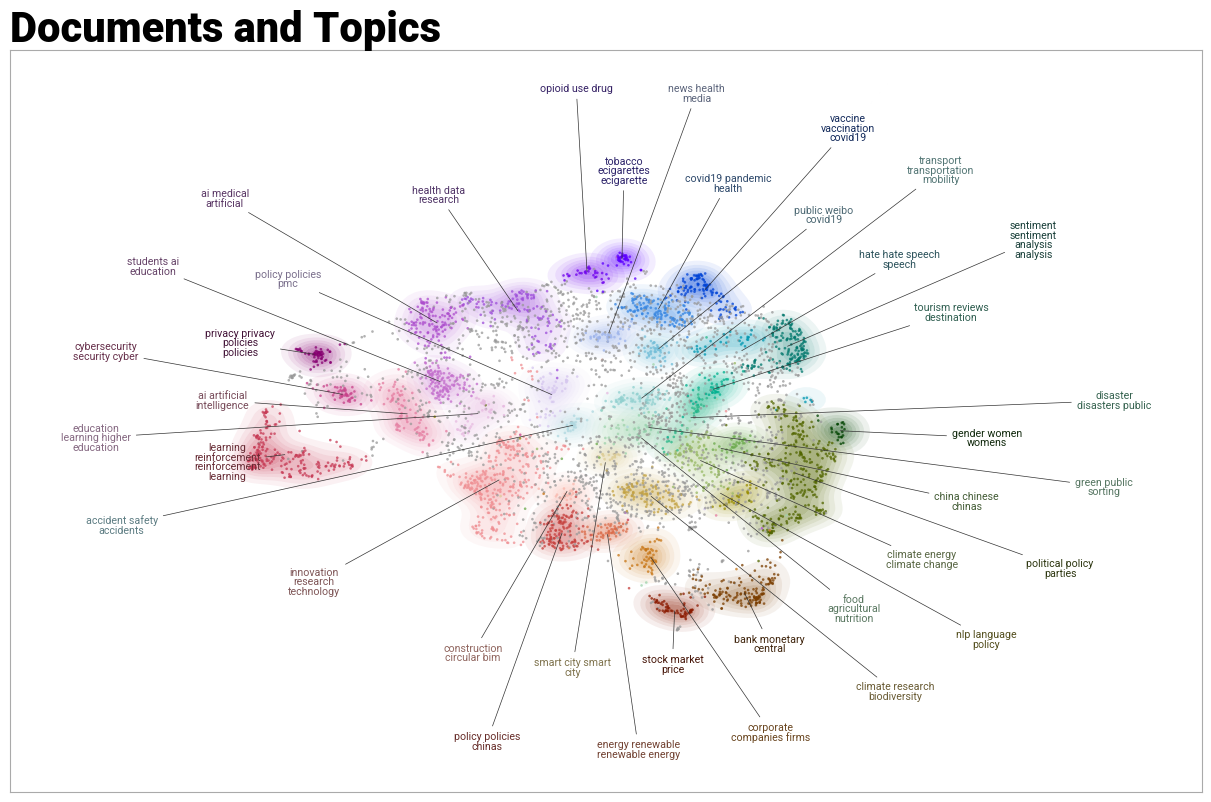

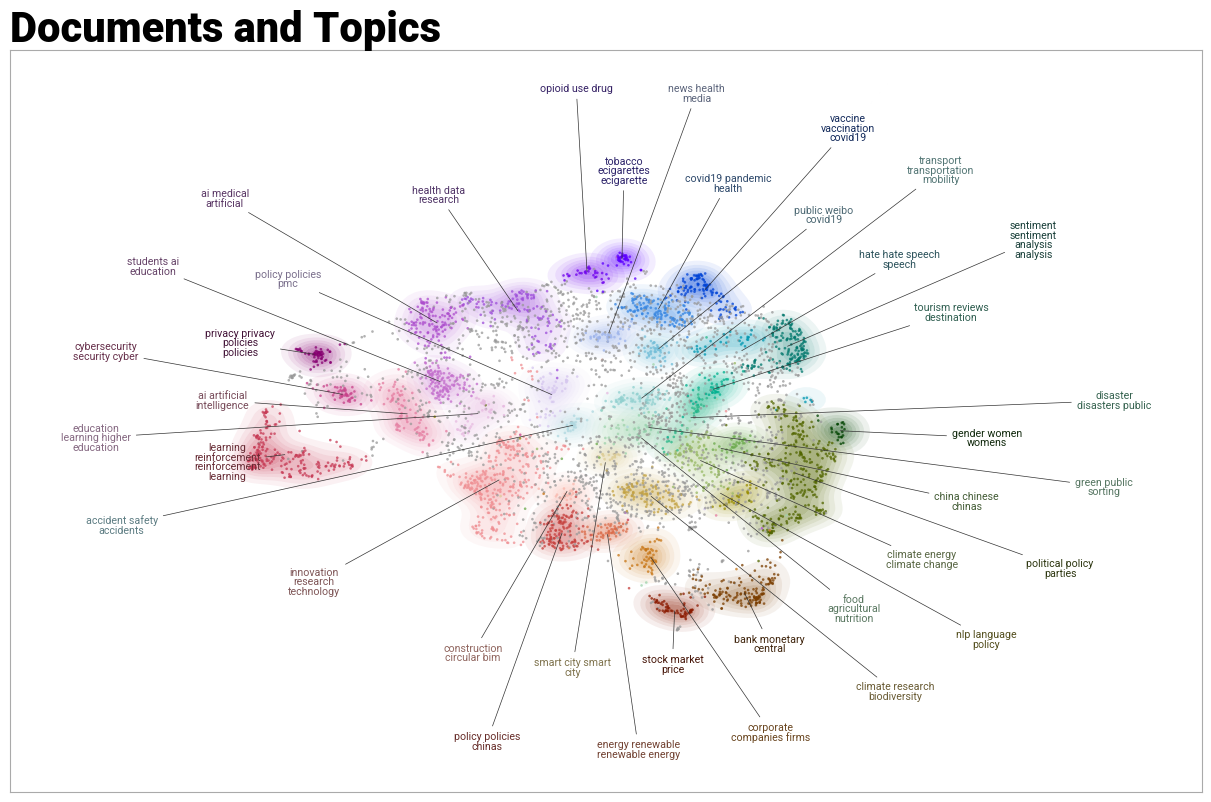

In [15]:
topic_model.visualize_document_datamap(docs, embeddings=embeddings)